In [ ]:
# @title Importing dependencies

from IPython.display import Image, SVG, display
import os
from pathlib import Path

import random
from tqdm import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torchvision
import contextlib
import io

In [ ]:
# @markdown `download_mnist()`: Function to download MNIST.

def download_mnist(train_prop=0.8, keep_prop=0.5):

  valid_prop = 1 - train_prop

  discard_prop = 1 - keep_prop

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307,), (0.3081,))]
      )


  with contextlib.redirect_stdout(io.StringIO()): #to suppress output

      full_train_set = torchvision.datasets.MNIST(
          root="./data/", train=True, download=True, transform=transform
          )
      full_test_set = torchvision.datasets.MNIST(
          root="./data/", train=False, download=True, transform=transform
          )

  train_set, valid_set, _ = torch.utils.data.random_split(
      full_train_set,
      [train_prop * keep_prop, valid_prop * keep_prop, discard_prop]
      )
  test_set, _ = torch.utils.data.random_split(
      full_test_set,
      [keep_prop, discard_prop]
      )

  print("Number of examples retained:")
  print(f"  {len(train_set)} (training)")
  print(f"  {len(valid_set)} (validation)")
  print(f"  {len(test_set)} (test)")

  return train_set, valid_set, test_set

In [ ]:
train_set, valid_set, test_set = download_mnist()

In [ ]:
#@markdown To get started exploring the dataset, here are a few plotting functions:

#@markdown `get_plotting_color()`: Returns a color for the specific dataset, e.g. "train" or model index.
def get_plotting_color(dataset="train", model_idx=None):
  if model_idx is not None:
    dataset = None

  if model_idx == 0 or dataset == "train":
    color = "#1F77B4" # blue
  elif model_idx == 1 or dataset == "valid":
    color = "#FF7F0E" # orange
  elif model_idx == 2 or dataset == "test":
    color = "#2CA02C" # green
  else:
    if model_idx is not None:
      raise NotImplementedError("Colors only implemented for up to 3 models.")
    else:
      raise NotImplementedError(
          f"{dataset} dataset not recognized. Expected 'train', 'valid' "
          "or 'test'."
          )

  return color


#@markdown `plot_examples(subset)`: Plot examples from the dataset organized by their predicted class
#@markdown (if a model is provided) or by their class label otherwise
def plot_examples(subset, num_examples_per_class=8, MLP=None, seed=None,
                  batch_size=32, num_classes=10, ax=None):
  """
  Function for visualizing example images from the dataset, organized by their
  predicted class, if a model is provided, or by their class, otherwise.

  Arguments:
  - subset (torch dataset or torch dataset subset): dataset from which to
    visualized images.
  - num_examples_per_class (int, optional): number of examples to visualize per
    class
  - MLP (MultiLayerPerceptron or None, optional): model to use to retrieve the
    predicted class for each image. If MLP is None, images will be organized by
    their class label. Otherwise, images will be organized by their predicted
    class.
  - seed (int or None, optional): Seed to use to randomly sample images to
    visualize.
  - batch_size (int, optional): If MLP is not None, number of images to
    retrieve predicted class for at one time.
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if MLP is None:
    xlabel = "Class"
  else:
    MLP.eval()
    xlabel = "Predicted class"

  if ax is None:
    fig_wid = min(8, num_classes * 0.6)
    fig_hei = min(8, num_examples_per_class * 0.6)
    _, ax = plt.subplots(figsize=(fig_wid, fig_hei))

  if seed is None:
    generator = None
  else:
    generator = torch.Generator()
    generator.manual_seed(seed)

  loader = torch.utils.data.DataLoader(
      subset, batch_size=batch_size, shuffle=True, generator=generator
      )

  plot_images = {i: list() for i in range(num_classes)}
  with torch.no_grad():
    for X, y in loader:
      if MLP is not None:
        y = MLP(X)
        y = torch.argmax(y, axis=1)

      done = True
      for i in range(num_classes):
        num_to_add = int(num_examples_per_class - len(plot_images[i]))
        if num_to_add:
          add_images = np.where(y == i)[0]
          if len(add_images):
            for add_i in add_images[: num_to_add]:
              plot_images[i].append(X[add_i, 0].numpy())
          if len(plot_images[i]) != num_examples_per_class:
            done = False

      if done:
        break

  hei, wid = X[0, 0].shape
  final_image = np.full((num_examples_per_class * hei, num_classes * wid), np.nan)
  for i, images in plot_images.items():
    if len(images):
      final_image[: len(images) * hei, i * wid: (i + 1) * wid] = np.vstack(images)

  ax.imshow(final_image, cmap="gray")

  ax.set_xlabel(xlabel)
  ax.set_xticks((np.arange(num_classes) + 0.5) * wid)
  ax.set_xticklabels([f"{int(i)}" for i in range(num_classes)])
  ax.set_yticks([])
  ax.set_title(f"Examples per {xlabel.lower()}")

  return ax

#@markdown `plot_class_distribution(train_set)`: Plots the distribution of classes in each set (train, validation, test).
def plot_class_distribution(train_set, valid_set=None, test_set=None,
                            num_classes=10, ax=None):
  """
  Function for plotting the number of examples per class in each subset.

  Arguments:
  - train_set (torch dataset or torch dataset subset): training dataset
  - valid_set (torch dataset or torch dataset subset, optional): validation
    dataset
  - test_set (torch dataset or torch dataset subset, optional): test
    dataset
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(6, 3))

  bins = np.arange(num_classes + 1) - 0.5

  for dataset_name, dataset in [
      ("train", train_set), ("valid", valid_set), ("test", test_set)
      ]:
    if dataset is None:
      continue

    if hasattr(dataset, "dataset"):
      targets = dataset.dataset.targets[dataset.indices]
    else:
      targets = dataset.targets

    outputs = ax.hist(
        targets,
        bins=bins,
        alpha=0.3,
        color=get_plotting_color(dataset_name),
        label=dataset_name,
        )

    per_class = len(targets) / num_classes
    ax.axhline(
        per_class,
        ls="dashed",
        color=get_plotting_color(dataset_name),
        alpha=0.8
        )

  ax.set_xticks(range(num_classes))
  ax.set_title("Counts per class")
  ax.set_xlabel("Class")
  ax.set_ylabel("Count")
  ax.legend(loc="center right")

  return ax

<Axes: title={'center': 'Examples per class'}, xlabel='Class'>

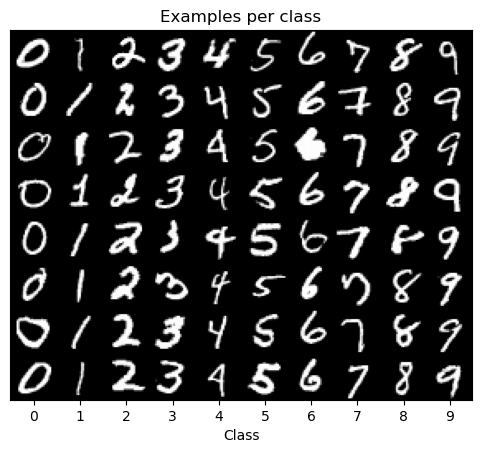

In [7]:
plot_examples(train_set)